In [1]:
import numpy as np
import math, pandas
import scipy
from scipy import sparse
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.dtm_rips_complex import DTMRipsComplex
from ripser import ripser
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers as layers
from gudhi.tensorflow import RipsLayer
from sys import exit
import seaborn as sns
from utilyze import *
import pickle

In [2]:
# Params for RFP data
number_pts = 150
alist = np.linspace(.50, .9, 10)
wlist = np.linspace(3, 10, 8)

In [3]:
# Computing jacobians

# params
xrange = [0.,1.]
yrange = [0.,1.]

number_pixel = 20
gauss_sigma = 0.001

maximal_edge_length_height = .1
maximal_edge_length_rips = 1.
maximal_edge_length_dtm = .5

linear_weighting = Weight(method='linear',b=yrange[1])
constant_weighting = Weight(method='constant')
# 
Pointclouds = {str(format(a, ".2f"))+','+str(format(w, ".2f")): RFP(a, w, 0, number_pts,normalize=True) for a in alist for w in wlist}


JAC_DTM = Collect_jacobian(dataset = Pointclouds,
                                 jacobian_method = get_jacobian_dtm,
                                 xrange = xrange,
                                 yrange = yrange, 
                                 number_pixel = number_pixel,
                                 gauss_sigma = gauss_sigma,
                                 weight_func = linear_weighting,
                                 max_edge_length=maximal_edge_length_dtm, 
                                 homology_dimensions=[1],
                                 normalize=False)  
JAC_HEIGHT = Collect_jacobian(dataset = Pointclouds,
                                 jacobian_method = get_jacobian_height, 
                                 xrange = xrange,
                                 yrange = yrange,
                                 number_pixel = number_pixel,
                                 gauss_sigma = gauss_sigma, 
                                 weight_func = constant_weighting,
                                 max_edge_length = maximal_edge_length_height, 
                                 homology_dimensions = [1],
                                 normalize = False)
JAC_RIPS = Collect_jacobian(dataset = Pointclouds,
                            jacobian_method = get_jacobian_rips,
                            xrange = xrange,
                            yrange = yrange, 
                            number_pixel = number_pixel,
                            gauss_sigma = gauss_sigma,
                            weight_func = linear_weighting,
                            max_edge_length = maximal_edge_length_rips, 
                            homology_dimensions = [1],
                            normalize = False)

2023-07-05 15:16:58.624365: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [4]:
# PointNet
random_seed()

data_pc = np.array([RFP(a, w, 0, number_pts, normalize=True) for a in alist for w in wlist])
labels = np.array([w-3 for _ in alist for w in wlist]).astype(np.int32)
input_shape = (number_pts, 2)
num_classes = 8
labels_onehot = tf.keras.utils.to_categorical(labels, num_classes) # Convert labels to one-hot encoding

# Create the PointNet architecture
def pointnet():
    input_points = Input(shape=input_shape)
    # PointNet architecture
    x = layers.Conv1D(64, kernel_size=1, padding="valid")(input_points)  #(bs, number_pts, 64)
    x = layers.BatchNormalization(momentum=0.0)(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalMaxPooling1D()(x) #(bs, 64)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_points, outputs=x)
    return model

pointnet_model = pointnet()
pointnet_model.compile(loss='categorical_crossentropy',
                       optimizer=Adam(learning_rate=1e-3),
                       metrics=['accuracy'])
train_data_pc, test_data_pc, train_labels, test_labels = train_test_split(data_pc, labels_onehot, test_size=0.2, random_state=0) # Train-test split
pointnet_model.fit(train_data_pc, train_labels, epochs=200, batch_size=64, validation_data=(test_data_pc, test_labels),verbose=0) # Train the model
loss, accuracy = pointnet_model.evaluate(test_data_pc, test_labels,verbose=0) # Evaluate the model
print("Test Accuracy for PointNet:", accuracy)
print("Test loss for PointNet:", loss)

pointnet_model.trainable = False
# Get the output of the second last layer
output = pointnet_model.layers[-2].output
# Create a new model that outputs the second last layer's output
second_last_model = tf.keras.models.Model(inputs=pointnet_model.input, outputs=output)
second_last_model.trainable = False

JAC_POINTNET = np.zeros((len(data_pc), 64, 2*number_pts))
for i,pc in enumerate(data_pc):
    x = tf.Variable(pc.reshape(-1,),dtype=tf.float32,trainable=True)
    with tf.GradientTape() as tape:
        pc_tensor = tf.reshape(x,(number_pts,2))
        pc_tensor = tf.expand_dims(pc_tensor, axis=0)  # Add batch dimension
        y = second_last_model(pc_tensor)[0,:]
    J = tape.jacobian(y, x)
    _, Sigma, _ = scipy.linalg.svd(J)
    if np.max(Sigma)>0:
        J /= np.max(Sigma)
    else:
        print('jac = 0')
    JAC_POINTNET[i,:] = J

Test Accuracy for PointNet: 1.0
Test loss for PointNet: 0.15163660049438477


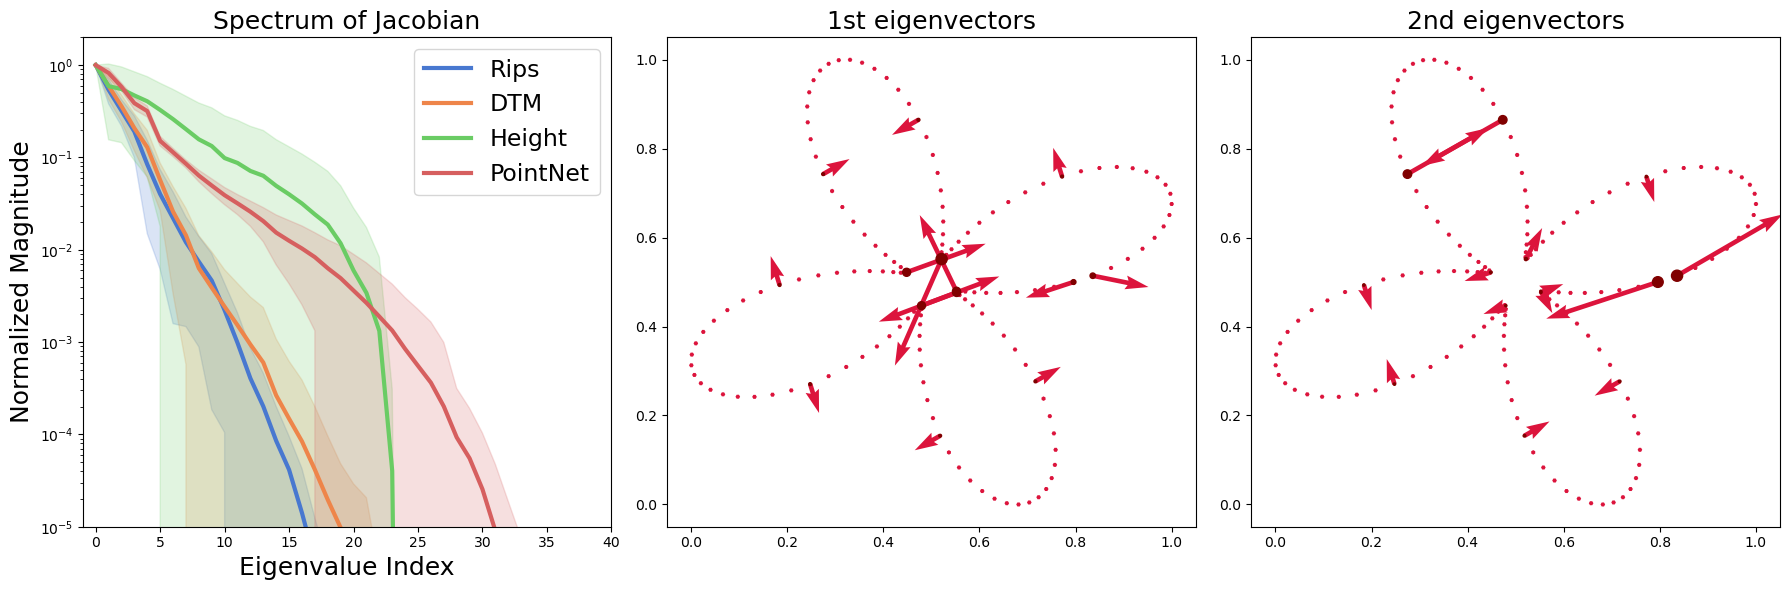

In [5]:
# spectrum

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
ax = axs[0]
FONTSIZE = 18
Jac = {'Rips':JAC_RIPS,
        'DTM':JAC_DTM,
        'Height':JAC_HEIGHT,
        'PointNet':JAC_POINTNET
        }
colors = plt.cm.get_cmap('viridis', len(Jac))
for i, (filtname, jac) in enumerate(Jac.items()):
    specs = []
    for j in jac:
        singularvalues = scipy.linalg.svd(j)[1] # j is already normalized
        specs.append(singularvalues)
    specs = np.array(specs)
    mean = np.mean(specs, axis=0)
    std = np.std(specs, axis=0)
    color = sns.color_palette('muted')[i]
    ax.plot(range(len(mean)), mean, color=color, label=filtname, linewidth=3)
    ax.fill_between(range(len(mean)), mean - std, mean + std, color=color, alpha=0.2)
ax.set_yscale('log')
ax.set_ylabel('Normalized Magnitude', fontsize=FONTSIZE)
ax.set_xlabel('Eigenvalue Index', fontsize=FONTSIZE)
ax.set_xlim([-1,40])
ax.set_ylim([1e-5,2.])
ax.legend(fontsize=FONTSIZE-1, title='')
ax.set_title("Spectrum of Jacobian", fontsize=FONTSIZE)

Pointclouds = {str(format(a, ".2f"))+','+str(format(w, ".2f")): RFP(a, w, 0, number_pts,normalize=True) for a in alist for w in wlist}
idx = list(Pointclouds.keys()).index('0.81,4.00')
pc = Pointclouds[list(Pointclouds.keys())[idx]]
column_labels = ['1st eigenvectors', '2nd eigenvectors']
j = JAC_RIPS[idx]
U, _, Vt = scipy.linalg.svd(j)
for k in range(2):
    ax = axs[k+1]
    v = Vt.T[:, k].reshape(-1, 2)
    saliency = np.linalg.norm(v,axis=1)
    saliency -= np.min(saliency)
    saliency /= np.max(saliency)
    ax.quiver(pc[:, 0], pc[:, 1], v[:, 0], v[:, 1], scale=2, color='crimson', angles='xy', units='xy', headlength=5, headwidth=3, width=0.01)
    ax.scatter(pc[:, 0], pc[:, 1], s=(saliency*8)**2, c='maroon', cmap='Reds')
    ax.set_xlim([-.05, 1.05])
    ax.set_ylim([-.05, 1.05])
    ax.set_title(column_labels[k], fontsize = FONTSIZE)

plt.tight_layout()
plt.savefig('figures/spec_rfp.png',dpi=300)

In [6]:
# Perturbations
Features = {
    'Rotation': rotate,
    'Translation': translation,
    'Dilation': dilation,
    'Strech_x': stretch_x,
    'Shearing': shear,
    'Noising': noising,
    'Wiggly': wiggly,
    'Convex': convex,
}
Features_params = {
    'Dilation': .25,
    'Strech_x': .35,
    'Noising': 10.,
    'Rotation': .001, 
    'Wiggly': .5,
    'Convex': 1.,
    'Translation': .1,
    'Shearing': .1,
}

In [7]:
# Alignment data
Pointclouds = {str(format(a, ".2f"))+','+str(format(w, ".2f")): RFP(a, w, 0, number_pts,normalize=True) for a in alist for w in wlist}

Data = {}
for filtname in Jac.keys():
    Data[filtname] = {}
    for featname in Features.keys():
           Data[filtname][featname] = []

#Var = {}
for _,(filtname, _) in enumerate(Jac.items()):
        jacs = Jac[filtname]
        for k, pc in enumerate(Pointclouds.values()):
                jac = jacs[k]
                _, _, Vt = scipy.linalg.svd(jac)
                V = Vt.T
                for _, (featname, feature) in enumerate(Features.items()):   
                        pc_new = feature(pc, Features_params[featname])
                        delta_pc = (pc_new-pc).reshape(-1,1)
                        if np.linalg.norm(delta_pc, 2) == 0:
                                print(featname)
                        delta_pc /= np.linalg.norm(delta_pc, 2)
                        cos_val = [ abs( (V[:,j].T @ delta_pc)[0] )  for j in range(4)] # absolute innerproduct
                        Data[filtname][featname].append(cos_val)
Aligns = {}
for filtname in Jac.keys():
    for i in range(4):
            name = filtname+'-'+str(i)
            Aligns[name] = {}
    for featname in Features.keys():
            cosvals = np.mean(Data[filtname][featname], axis=0)
            for i in range(4):
                name = filtname+'-'+str(i)
                Aligns[name][featname] = cosvals[i]
df = pandas.DataFrame.from_dict(Aligns, orient='index')
df = df.transpose()

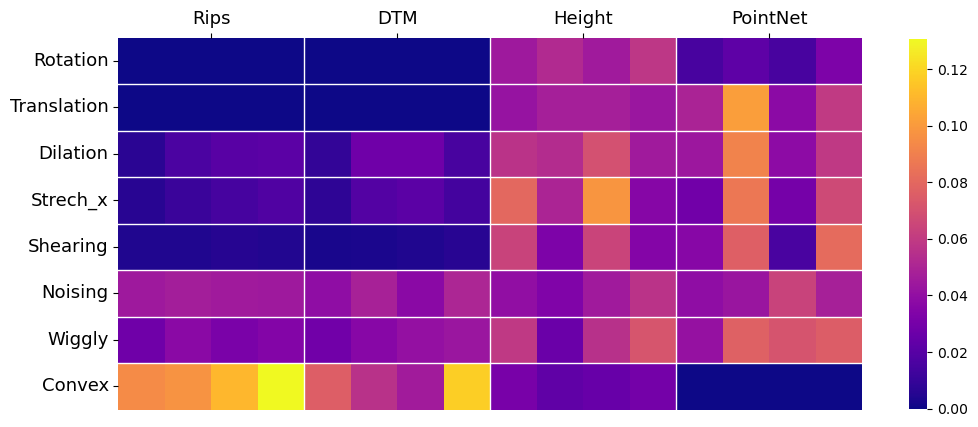

In [8]:
plt.figure(figsize=(12, 6))

ax = sns.heatmap(df, annot=False, cmap="plasma", square=True, cbar_kws={"shrink": 0.8})
# Add vertical lines every 4 columns
for i in range(1, df.shape[1]):
    if i % 4 == 0:
        ax.axvline(i, color='white', lw=1)
for i in range(1, df.shape[0]):
    ax.axhline(i, color='white', lw=1)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
#Set custom x-axis tick labels for every 4 columns
x_tick_labels = ['Rips', 'DTM', 'Height', 'PointNet']
x_ticks = [i * 4 + 2 for i in range(len(x_tick_labels))]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)

plt.savefig('Figures/align.png', dpi=300)

In [9]:
# Computing pull-back norms of perturbation vector fields
list_pbnorms = []
for encoding, data_jacobian in Jac.items():
    # Put pbnorms of all pc wrt one feature into one list
    pbns = {}
    for key in Features.keys():
        pbns[key] = []

    for i, (pcname, pc) in enumerate(Pointclouds.items()): 
        jacobian = data_jacobian[i]
        for j, (featname, feature) in enumerate(Features.items()):        
            pc_new = feature(pc, Features_params[featname])
            vec_perturb = (pc_new-pc).reshape(-1,1)
            if np.linalg.norm(vec_perturb, 2) == 0:
                print(pcname, featname)
            vec_perturb /= np.linalg.norm(vec_perturb, 2) # normalize
            pullback_norm = np.linalg.norm(jacobian @ vec_perturb, 2)
            pbns[featname].append(pullback_norm)
    if encoding == 'Rips':
        PBNORM_RIPS = pbns
    elif encoding == 'DTM':
        PBNORM_DTM = pbns
    elif encoding == 'Height':
        PBNORM_HEIGHT = pbns
    elif encoding == 'PointNet':
        PBNORM_POINTNET = pbns

In [10]:
# Bures-Wasserstein distance between Grams
ep = 1e-5
def mat_square_root(A):
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        sqrt_eigenvalues = np.sqrt(eigenvalues)
        sqrt_A = eigenvectors @ np.diag(sqrt_eigenvalues) @ np.linalg.inv(eigenvectors)
        return sqrt_A
def Bures_wass(A,B):
        '''
        A,B : Positive definite

        '''
        sqrt_A = mat_square_root(A)
        C = sqrt_A @ B @ sqrt_A
        sqrt_C = mat_square_root(C)
        d = np.trace(A) + np.trace(B) - 2*np.trace(sqrt_C)
        if abs(d)<1e-7:
                d=0.
        d **= .5
        return d

Data = {}
Var = {}
for i,(key1, value1) in enumerate(Jac.items()):
        jacs1 = Jac[key1]
        for j,(key2, value2) in enumerate(Jac.items()):
                jacs2 = Jac[key2]
                dists = []
                for k in range(JAC_RIPS.shape[0]):
                        jac1 = jacs1[k]
                        G1 = jac1.T @ jac1 + ep * np.identity(jac1.shape[1])
                        jac2 = jacs2[k]
                        G2 = jac2.T @ jac2 + ep * np.identity(jac2.shape[1])
                        dist = Bures_wass(G1,G2)
                        if np.isnan(dist):
                                print(key1,key2)
                        dists.append(dist)
                Data[key1+' '+key2] = np.mean(dists)
                Var[key1+' '+key2] = np.var(dists)**.5

dictionary = Data
keys = list(dictionary.keys())
values = list(dictionary.values())
columns = [key.split() for key in keys]
mean = pandas.DataFrame(columns, columns=['Column 1', 'Column 2'])
mean['Value'] = values
dictionary = Var
keys = list(dictionary.keys())
values = list(dictionary.values())
columns = [key.split() for key in keys]
var = pandas.DataFrame(columns, columns=['Column 1', 'Column 2'])
var['Value'] = values

corr_matrix = mean.pivot(index='Column 1', columns='Column 2', values='Value')
std_error_matrix = var.pivot(index='Column 1', columns='Column 2', values='Value')
column_order = ['Rips', 'DTM', 'Height', 'PointNet']
corr_matrix = corr_matrix.reindex(columns=column_order)
corr_matrix = corr_matrix.reindex(index=column_order)
std_error_matrix = std_error_matrix.reindex(columns=column_order)
std_error_matrix = std_error_matrix.reindex(index=column_order)

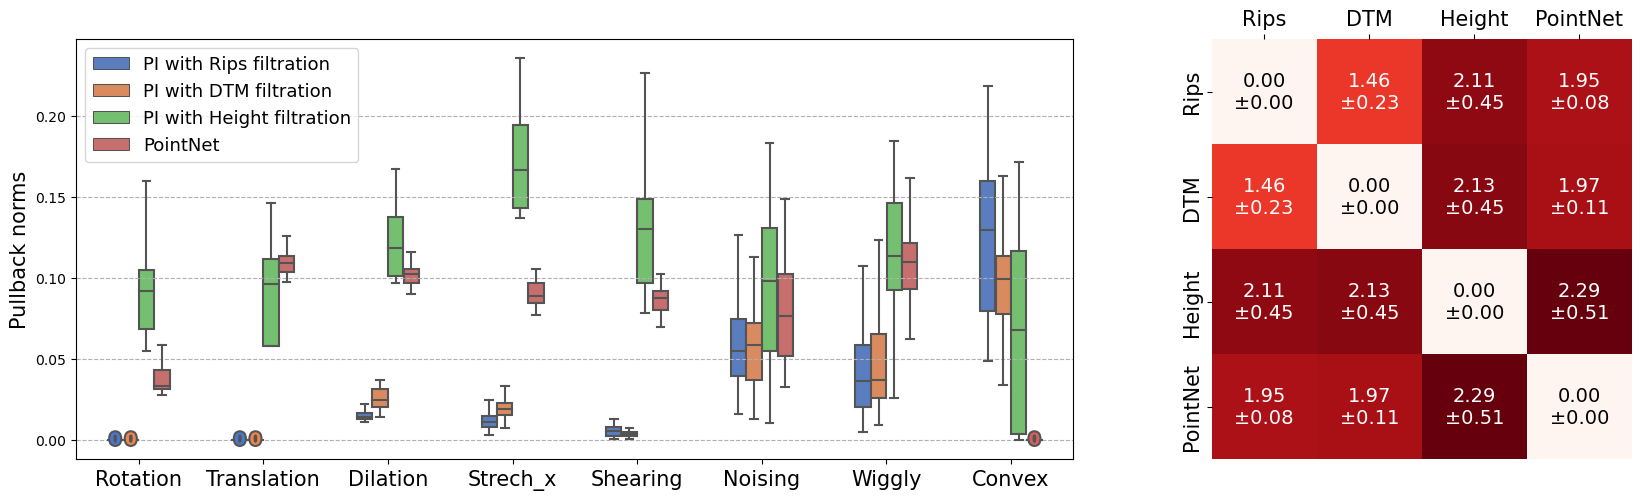

In [11]:
# Visualization
FS = 15 # fontsize
import seaborn as sns
data = []
for key in PBNORM_RIPS:
    data.extend([
        {'Perturbation': key, 'Pullback norms': value, 'Representation': 'PI with Rips filtration'}
        for value in PBNORM_RIPS[key]
    ])
for key in PBNORM_DTM:
    data.extend([
        {'Perturbation': key, 'Pullback norms': value, 'Representation': 'PI with DTM filtration'}
        for value in PBNORM_DTM[key]
    ])
for key in PBNORM_HEIGHT:
    data.extend([
        {'Perturbation': key, 'Pullback norms': value, 'Representation': 'PI with Height filtration'}
        for value in PBNORM_HEIGHT[key]
    ])
for key in PBNORM_POINTNET:
    data.extend([
        {'Perturbation': key, 'Pullback norms': value, 'Representation': 'PointNet'}
        for value in PBNORM_POINTNET[key]
    ])
df = pandas.DataFrame(data)
df['Perturbation'] = df['Perturbation'].replace('Tranlation', 'Translation')

#
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

ax = axs[0]
sns.boxplot(x='Perturbation', y='Pullback norms', hue='Representation', data=df, palette='muted', width=0.5, showfliers=False, ax=ax)
import matplotlib.patheffects as path_effects
def add_median_labels(ax, fmt='.1f'):
    c = sns.color_palette("muted", 4)
    i =0 
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        if i in [0,1,4,5,31]:
            value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
            text = ax.text(x, y, '0', 
                        ha='center', 
                        va='center',
                        fontweight='bold',
                        #color='white',
                        color = c[i%4],
                        fontsize=12)
            # create median-colored border around white text for contrast
            text.set_path_effects([
                path_effects.Stroke(linewidth=3, foreground=median.get_color()),
                path_effects.Normal(),
            ])
        i+=1
add_median_labels(ax)
ax.grid(axis='y', linestyle='dashed')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=15)
ax.set_xlabel("")
ax.set_ylabel('Pullback norms', fontsize=15)
ax.legend(fontsize=13)

ax1 = sns.heatmap(corr_matrix, annot=False, cmap='Reds', square=True, ax=axs[1], cbar=False)
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        value = corr_matrix.iloc[i, j]
        std_error = std_error_matrix.iloc[i, j]
        annotation_text = f"{value:.2f}\n±{std_error:.2f}"
        if i != j:
            ax1.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color='white', fontsize=14)
        elif i == j:
            ax1.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color='black', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=15)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=15)
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')
ax1.set_xlabel("")
ax1.set_ylabel("")


# Display the plot
plt.tight_layout(pad=5.0)
plt.savefig('Figures/sense-compare.png',dpi=300)